# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: *Caterina Alfano*

**Matricola**: *1746299*

Send the completed notebook before 26/11/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [2]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [6]:
import math

class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__(self)
        self.units = units

    def build(self, input_shape):

        a_init = tf.random.uniform((self.units,), minval=3, maxval=None, dtype=tf.dtypes.float32, seed=123, name=None)
        self.a = tf.Variable(a_init, trainable=True)
        b_init = tf.random.uniform((self.units,), minval=3, maxval=None, dtype=tf.dtypes.float32, seed=123, name=None)
        self.b = tf.Variable(b_init, trainable=True)

    
    def call(self, inputs):
 
        output = tf.where(inputs>=0, tf.math.multiply(tf.math.divide(self.a, self.b),inputs), tf.math.multiply(tf.math.subtract(tf.math.exp(tf.math.minimum(tf.math.divide(inputs, self.b),0)),1),self.a))
        
        return output

    def get_config(self):
        
        return {"units": self.units}
        

**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [17]:
tf.random.set_seed(111)
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



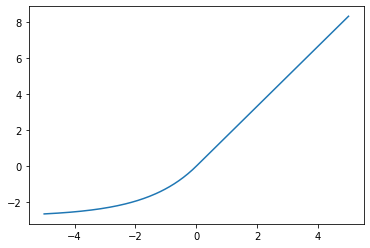

In [18]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]
y_range = pelu(x_range)

plt.plot(x_range.numpy(), y_range.numpy())

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [20]:
#getting the derivatives with GradientTape
delta = pelu.a
with tf.GradientTape() as g:
  y = pelu(x_range)
dy_dx = g.jacobian(y, delta)

grads = tf.reshape(dy_dx, shape=(200,1))
#print(grads)

In [21]:
#getting the derivatives by hand
beta = pelu.b[0].numpy()

derivatives = []
for i in x_range: 
  if i >= 0:
      derivatives.append([i/ beta])
  else:
      derivatives.append([math.exp(i/ beta)-1])

derivatives = tf.convert_to_tensor(derivatives, dtype="float32")
#print(derivatives)

In [22]:
#compare the resutls
tf.reduce_all(tf.abs(grads - derivatives) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 2.3

In [23]:
#Let's do the same thing but with the derivative w.r.t b

#first we get the gradient with gradient tape
delta = pelu.b
with tf.GradientTape() as g:
  y = tf.convert_to_tensor(pelu(x_range))
dy_dx = g.jacobian(y, delta)

grads = tf.reshape(dy_dx, shape=(200,1))

#then we compute it by hand
beta = beta = pelu.b[0].numpy()
alpha = pelu.a[0].numpy()
derivatives = []
for i in x_range: 
  if i >= 0:
      derivatives.append([- (alpha/(beta**2))*i])
  else:
      derivatives.append([-(alpha*i*math.exp(i/beta))/(beta**2)])

derivatives = tf.convert_to_tensor(derivatives, dtype="float32")

In [24]:
#and now we can check the results
tf.reduce_all(tf.abs(grads - derivatives) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In [25]:
#Fetching the dataset
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00325/Sensorless_drive_diagnosis.txt

--2020-11-23 17:35:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00325/Sensorless_drive_diagnosis.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25619870 (24M) [application/x-httpd-php]
Saving to: ‘Sensorless_drive_diagnosis.txt’

Sensorless_drive_di 100%[===================>]  24.43M  48.2MB/s    in 0.5s    

2020-11-23 17:35:37 (48.2 MB/s) - ‘Sensorless_drive_diagnosis.txt’ saved [25619870/25619870]



In [26]:
#Preparing the dataset
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import Sequential
from sklearn import model_selection
import pandas as pd

sensorless = pd.read_csv('Sensorless_drive_diagnosis.txt', header=None, sep=' ')
X = sensorless.values[:, 0:-1].astype('float32')
y = sensorless.values[:, -1:].astype('int64') - 1
X_tr, X_tst, y_tr, y_tst = model_selection.train_test_split(X, y, stratify=y)
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
train_dataset = train_dataset.shuffle(1000).batch(32)

def take_first_element(xb, yb):
  return xb

normalizer = Normalization()
normalizer.adapt(train_dataset.map(take_first_element))

test_dataset = tf.data.Dataset.from_tensor_slices((X_tst, y_tst)).batch(32)

In [29]:
#Preparing the model 
tf.random.set_seed(1900)
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics


model = tf.keras.Sequential(layers=[
      normalizer,
      tf.keras.layers.Dense(50),
      PELU(50) ,
      tf.keras.layers.Dense(11, activation='softmax')
])

adam = optimizers.Adam(learning_rate=1e-3)
cross_entropy = losses.SparseCategoricalCrossentropy()
acc = metrics.SparseCategoricalAccuracy()

#model.build((32,48))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 48)                97        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2450      
_________________________________________________________________
pelu_6 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 11)                561       
Total params: 3,208
Trainable params: 3,111
Non-trainable params: 97
_________________________________________________________________


In [30]:
model.compile(optimizer=adam,
              loss=cross_entropy,
              metrics=[acc])

In [31]:
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.7378 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.3115 - val_sparse_categorical_accuracy: 0.9122
Epoch 2/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.2312 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.2167 - val_sparse_categorical_accuracy: 0.9362
Epoch 3/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9455 - val_loss: 0.1879 - val_sparse_categorical_accuracy: 0.9506
Epoch 4/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9546 - val_loss: 0.1610 - val_sparse_categorical_accuracy: 0.9560
Epoch 5/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.1501 - val_sparse_categorical_accuracy: 0.9583
Epoch 6/10
1372/1372 [==============================] - 4s 3ms/step - loss: 0.1150 - spars

In [32]:
#Comparing it with a model that uses a ReLu
#tf.random.set_seed(1900)

model2 = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      tf.keras.layers.ReLU(50) ,
      tf.keras.layers.Dense(11, activation='softmax')
])

adam = optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=adam,
              loss=cross_entropy,
              metrics=[acc])

model2.fit(train_dataset, epochs=10, validation_data=test_dataset) 

Epoch 1/10
1372/1372 [==============================] - 3s 2ms/step - loss: 2.2189 - sparse_categorical_accuracy: 0.4330 - val_loss: 1.8125 - val_sparse_categorical_accuracy: 0.4141
Epoch 2/10
1372/1372 [==============================] - 3s 2ms/step - loss: 1.5617 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.3294 - val_sparse_categorical_accuracy: 0.5891
Epoch 3/10
1372/1372 [==============================] - 3s 2ms/step - loss: 1.1558 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.0048 - val_sparse_categorical_accuracy: 0.6832
Epoch 4/10
1372/1372 [==============================] - 3s 2ms/step - loss: 0.8901 - sparse_categorical_accuracy: 0.7228 - val_loss: 0.8018 - val_sparse_categorical_accuracy: 0.7477
Epoch 5/10
1372/1372 [==============================] - 3s 2ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.7811 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.7935
Epoch 6/10
1372/1372 [==============================] - 3s 2ms/step - loss: 0.5962 - spars

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [33]:
model.save('pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('pelu_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pelu_model/assets


In [34]:
print("Original model:", model)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

Original model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc1a8668a20>
Loaded model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc1a17490b8>


### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.